# 載入套件 Loading Package

In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 初始化 Initial

In [0]:
DATASET_PATH = '/content/drive/My Drive/Colab Notebooks/DogVsCat/dogs-cats-small-dataset' # 資料路徑
IMAGE_SIZE = (224, 224) # 影像大小
NUM_CLASSES = 2         # 影像類別數量
BATCH_SIZE = 8          # 若 GPU 記憶體不足，可調降 batch size 或 凍結更多層網路
FREEZE_LAYERS = 2       # 凍結網路層數
NUM_EPOCHES = 50        # Epoch 數量
WEIGHTS_FINAL = 'model-DenseNet201-final.h5' # 模型輸出儲存的檔案

# 資料增強 Data augmentation

In [3]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/validation',
                                                 target_size= IMAGE_SIZE,
                                                 interpolation= 'bicubic',
                                                 class_mode= 'categorical',
                                                 shuffle= False,
                                                 batch_size=BATCH_SIZE)
# 輸出各類別的索引
for c, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, c))

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Class #0 = cats
Class #1 = dogs


# 建立模型 Build Model

In [4]:
# 捨棄 DenseNet201 的 fully connected layers
net = DenseNet201(include_top=False, 
                  weights='imagenet', 
                  input_tensor=None,
                  input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

for layer in net.layers:
    layer.trainable = True

x = net.output
# BN-relu + GAP2D
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = GlobalAveragePooling2D()(x)
# 增加 Dense layer，以 softmax 產生各類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

net_final = Model(inputs=net.input, outputs=output_layer)
    
# 使用 Adam optimizer，以較低的 learning rae 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

74842112/74836368 [==============================] - 2s 0us/step


# 網路結構 Net Structure

In [5]:
# 輸出整個網路結構
print(net_final.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

# 訓練模型 Training Model

In [6]:
history = net_final.fit_generator(train_batches,
                                  steps_per_epoch= train_batches.samples // BATCH_SIZE, 
                                  validation_data= valid_batches,
                                  validation_steps= valid_batches.samples // BATCH_SIZE,
                                  epochs= NUM_EPOCHES)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
25/25 [==============================] - 177s 7s/step - loss: 0.6621 - accuracy: 0.5900 - val_loss: 0.5009 - val_accuracy: 0.8333
Epoch 2/50
25/25 [==============================] - 5s 190ms/step - loss: 0.4841 - accuracy: 0.8400 - val_loss: 0.3154 - val_accuracy: 0.9271
Epoch 3/50
25/25 [==============================] - 5s 191ms/step - loss: 0.3843 - accuracy: 0.9000 - val_loss: 0.2196 - val_accuracy: 0.9792
Epoch 4/50
25/25 [==============================] - 5s 191ms/step - loss: 0.2975 - accuracy: 0.9400 - val_loss: 0.1721 - val_accuracy: 0.9792
Epoch 5/50
25/25 [==============================] - 5s 193ms/step - loss: 0.2360 - accuracy: 0.9400 - val_loss: 0.1412 - val_accuracy: 0.9792
Epoch 6/50
25/25 [==============================] - 5s 191ms/step - loss: 0.1681 - accuracy: 0.9750 - val_loss: 0.1191 - val_accuracy: 0.9792
Epoch 7/50
25/25 [==============================] - 5s 191ms/step - loss:

# 儲存模型 Save Model

In [0]:
net_final.save(WEIGHTS_FINAL)

# 視覺化 Visualize
    觀察 accuracy、loss 變化

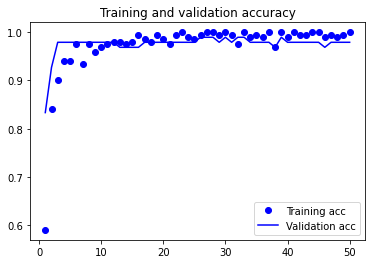

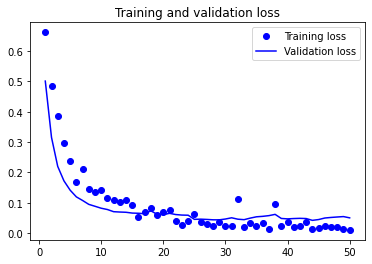

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()